## FRAUD DETECTION IN ELECTRICITY AND GAS CONSUMPTION CHALLENGE

* Import Libraries
* Basic EDA
* feature Engineering
* Modelling
* Prediction
* Submission

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time

seed = 47


In [4]:
invoice_test = pd.read_csv("../test/invoice_test.csv")

invoice_train = pd.read_csv("../train/invoice_train.csv")

client_test = pd.read_csv("../test/client_test.csv")
client_train = pd.read_csv("../train/client_train.csv")

/tmp/ipykernel_139139/998130178.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv("../train/invoice_train.csv")


Exploratory Data Analysis

In [6]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [21]:
client_train.rename(columns={'disrict':'district'}, inplace=True)

In [22]:
client_train.head()

,district,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [23]:
client_train.shape

(135493, 6)

There are 135493 rows and 6 columns in the client_train dataset.

Grouping by target and client_id in the client_train dataset

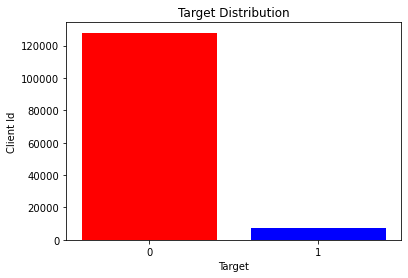

In [24]:
df_client_train = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=df_client_train.index, height=df_client_train.values, tick_label=[0,1], color=['red', 'blue'])
plt.title('Target Distribution')
plt.ylabel("Client Id")
plt.xlabel("Target")
plt.show()

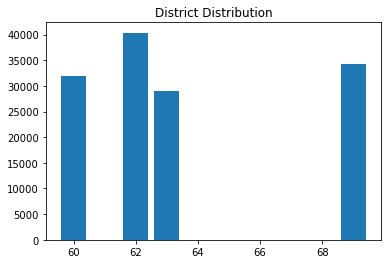

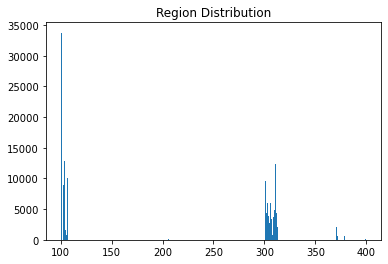

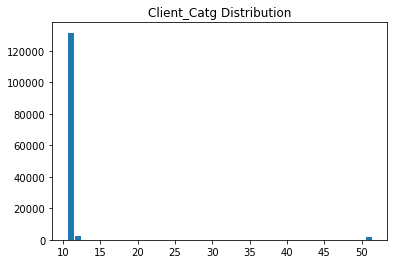

In [31]:
for col in ['district', 'region', 'client_catg']:
    df_client_train = client_train.groupby([col])['client_id'].count()
    plt.bar(x=df_client_train.index, height=df_client_train.values)
    plt.title(col.title() + ' Distribution')
    plt.show()

In [35]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [34]:
invoice_train.nunique()

client_id               135493
invoice_date              8275
tarif_type                  17
counter_number          201893
counter_statue              16
counter_code                42
reading_remarque             8
counter_coefficient         16
consommation_level_1      8295
consommation_level_2     12576
consommation_level_3      2253
consommation_level_4     12075
old_index               155648
new_index               157980
months_number             1370
counter_type                 2
dtype: int64

In [32]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


Find the number of missing values in the dataset

In [45]:
print("Number of missing numbers in invoice_train:", invoice_train.isnull().sum().sum())

print("Number of missing values in invoice_test: ", invoice_test.isnull().sum().sum(), '\n')

print("Number of missing values in client_train:", client_train.isnull().sum().sum())

print("Number of missing values in client_test: ", client_test.isnull().sum().sum())

Number of missing numbers in invoice_train: 0
Number of missing values in invoice_test:  0 

Number of missing values in client_train: 0
Number of missing values in client_test:  0


Number of unique values in invoice_train dataset

In [46]:
invoice_train.nunique()

client_id               135493
invoice_date              8275
tarif_type                  17
counter_number          201893
counter_statue              16
counter_code                42
reading_remarque             8
counter_coefficient         16
consommation_level_1      8295
consommation_level_2     12576
consommation_level_3      2253
consommation_level_4     12075
old_index               155648
new_index               157980
months_number             1370
counter_type                 2
dtype: int64

## FEATURE ENGINEERING

In [47]:
client_train.head()

,district,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [48]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [49]:
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   district       135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB
